In [1]:
%matplotlib inline
import mdtraj as md

from pylab import *
from math import pi
import numpy as np
import freud
from scipy.spatial import distance

In [2]:
import signac
import pandas as pd
import matplotlib
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

project = signac.get_project(root='../')
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
#print(df_index)
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df = pd.DataFrame(statepoints).T.join(df_index)
df.tail()

,NPROCS,P,T,filter_group,job_type,output_type,simulation_engine,simulation_time,stride,tau_profiling,...,data_management_time_s,ete_analysis_time_s,read_frames_time,root,signac_id,simulation_time_s,statepoint,total_data_read_time_s,total_time_s,workflow_type
41d804533356e20917897e45a8505071,1,1,300,"[Protein_NA_bound, 21]",plumed_sequential,xtc,gromacs,2000,100,True,...,0.176397,NaN,NaN,/home/sthomas/projects/goal1/project/workspace,41d804533356e20917897e45a8505071,110.172215,"{'NPROCS': 1, 'T': 300, 'P': 1, 'simulation_ti...",NaN,121.523752,Workflow 2
91744f3151b5cd684d52e2b168338b42,1,1,300,"[Protein_NA_bound, 21]",traditional,xtc,gromacs,2000,10,True,...,1.726534,1.546315,0.805516,/home/sthomas/projects/goal1/project/workspace,91744f3151b5cd684d52e2b168338b42,108.840466,"{'NPROCS': 1, 'T': 300, 'P': 1, 'simulation_ti...",NaN,113.465639,Workflow 1
c71ae9fe7c5c9f0d451a3abf7f2929f6,1,1,300,"[Protein_NA_bound, 21]",plumed_ds_concurrent,xtc,gromacs,2000,10,True,...,1510.542709,NaN,NaN,/home/sthomas/projects/goal1/project/workspace,c71ae9fe7c5c9f0d451a3abf7f2929f6,125.104642,"{'NPROCS': 1, 'T': 300, 'P': 1, 'simulation_ti...",820.755239,824.311381,Workflow 4
d1ba80f48913b53f526c97fe148f9cb4,1,1,300,"[Protein_NA_bound, 21]",plumed_ds_sequential,xtc,gromacs,2000,100,True,...,43.312037,NaN,NaN,/home/sthomas/projects/goal1/project/workspace,d1ba80f48913b53f526c97fe148f9cb4,121.307259,"{'NPROCS': 1, 'T': 300, 'P': 1, 'simulation_ti...",NaN,168.100623,Workflow 3
e21a8c8b2973f907f62eba85205caa90,1,1,300,"[Protein_NA_bound, 21]",traditional,xtc,gromacs,2000,100,True,...,1.464566,1.612787,0.677564,/home/sthomas/projects/goal1/project/workspace,e21a8c8b2973f907f62eba85205caa90,112.955434,"{'NPROCS': 1, 'T': 300, 'P': 1, 'simulation_ti...",NaN,118.098562,Workflow 1


In [76]:
def pbc_min_image(p1, p2, axes):
    dr = p1 - p2
    for i, p in enumerate(dr):
        if abs(dr[i]) > axes[i]*0.5:
            p2[i] = p2[i] + np.sign(dr[i])*axes[i] # Use dr to decide if we need to add or subtract axis
    return p2

def pbc_traslate(points, axes):
    '''Translates a group of points to the minimum image of first point in list
    points: list of poits
    axes: array, Lx, Ly, Lz
    We assume a tetragonal unit cell
    By default, all points will be translated into the minimum image
    of the first point, but any point can be used
    '''
    ref_point=points[0]
    # Add our min vector to our point
    min_image_cords = [pbc_min_image(ref_point, point, axes) for point in points[1:]] # Skip over the first point since its our ref point
    min_image_cords.insert(0, ref_point) # Don't forget to add the ref point into the list of points
    return np.asarray(min_image_cords)

def com(points, masses):
    #print(masses,points)
    weighted = masses[:,None]*points
    M = np.sum(masses)
    return np.sum(weighted,axis=0)/M#, M

def get_atoms_groups(topology, group_method='residue'):
    if group_method == 'residue':
        atom_indices = [[a.index for a in r.atoms] for r in topology.residues if r.is_protein]
    return np.asarray(atom_indices)

def get_masses(topology, group_method=None):
    if group_method == 'residue':
        masses = [np.asarray([a.element.mass for a in r.atoms]) for r in topology.residues if r.is_protein]
    elif group_method == None:
        masses = [a.element.mass for a in topology.atoms]
    else:
        raise NotImplementedError('get_masses not implemented')
    return np.asarray(masses)

def get_distances(atom_groups, xyzs, use_COM=True, masses=None):
    if use_COM and masses is not None:   
        coms_by_resid = [com(xyzs[r],masses[r]) for r in atom_groups]
        coords = np.asarray(coms_by_resid)
        #print(coords)
        distances = distance.cdist(coords, coords, 'euclidean')
        #distances = coms_by_resid
    else:
        raise ValueError('use_COM=False is not implemented')
    return distances

<Figure size 700x600 with 0 Axes>

/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


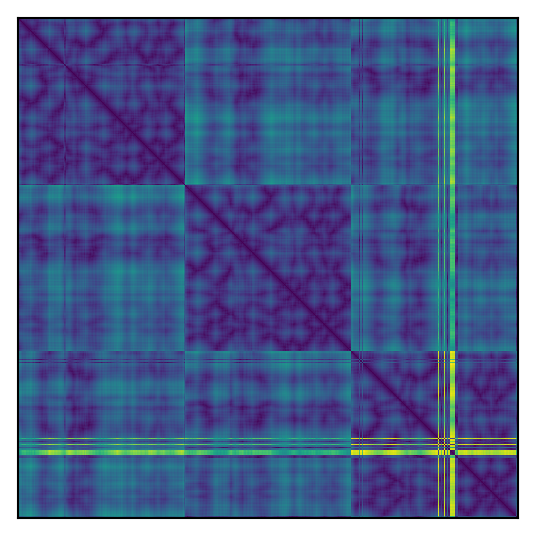

In [79]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Distance Matrix', artist='gltph',
                comment='Stride=100')
writer = FFMpegWriter(fps=5, metadata=metadata)


df_filtered = df[(df.job_type=='traditional')&
                 (df.stride==100)]
plt.figure()
fig, ax = plt.subplots()
for jobid in df_filtered.index:
    job = project.open_job(id=jobid)
    traj = md.load(job.fn('traj_comp.xtc'),top=job.fn('reference.pdb'))
    atom_indices_by_resid = get_atoms_groups(traj.topology)
    masses = get_masses(traj.topology)
    indices = [a.index for a in traj.topology.atoms]
    ims = []
    #with writer.saving(fig, job.fn("writer_test.mp4"),dpi=100):
    for i in range(traj.n_frames):
        min_img_cords = pbc_traslate(traj.xyz[i],traj.unitcell_lengths[i])
        dist_matrix = get_distances(atom_indices_by_resid,min_img_cords,masses=masses)
        im = ax.imshow(dist_matrix, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        ims.append([im])
        plt.draw()
        #break
        #writer.grab_frame()
            
    ani = manimation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    ani.save(job.fn('dis.gif'),writer='imagemagick')

In [23]:
import gsd
import gsd.fl
import numpy
import gsd.hoomd
def create_frame(i, positions):
    s = gsd.hoomd.Snapshot()
    s.configuration.step = i
    s.particles.N = len(positions)
    s.particles.position = positions
    return s

df_filtered = df[(df.job_type=='traditional')&
                 (df.stride==100)]

for jobid in df_filtered.index:
    job = project.open_job(id=jobid)
    traj = md.load(job.fn('traj_comp.xtc'),top=job.fn('reference.pdb'))
    atom_indices_by_resid = get_atoms_groups(traj.topology)
    masses = get_masses(traj.topology)
    indices = [a.index for a in traj.topology.atoms]
    with gsd.hoomd.open(name=job.fn('test.gsd'), mode='wb') as f:
        for i in range(traj.n_frames):
            min_img_cords = pbc_traslate(traj.xyz[i],traj.unitcell_lengths[i])
            coms_by_resid = [com(min_img_cords[r],masses[r]) for r in atom_indices_by_resid]
            f.append(create_frame(i,coms_by_resid))

        

In [5]:
psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
angles = md.compute_dihedrals(traj, [phi_indices, psi_indices])

(-3.141592653589793, 3.141592653589793)

/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sthomas/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


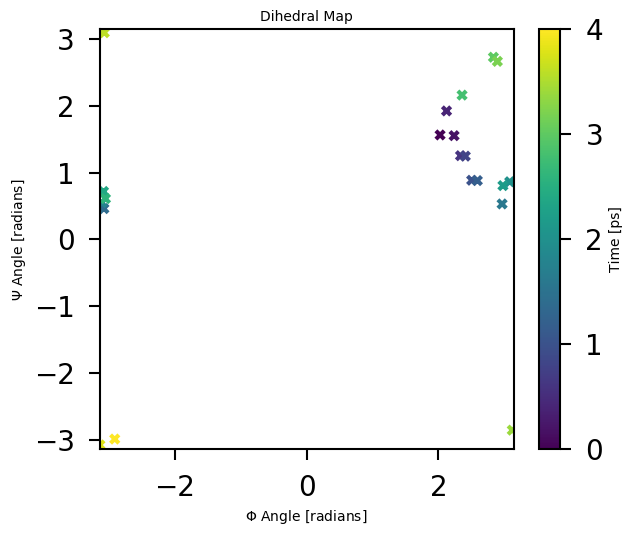

In [6]:
figure()
title('Dihedral Map', fontsize=10)
scatter(angles[:, 0], angles[:, 1], marker='x', c=traj.time)
cbar = colorbar()
cbar.set_label('Time [ps]', fontsize=10)
xlabel(r'$\Phi$ Angle [radians]', fontsize=10)
xlim(-pi, pi)
ylabel(r'$\Psi$ Angle [radians]', fontsize=10)
ylim(-pi, pi)